# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [53]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from Customer_Segmentation import clean_data
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [54]:
# Read a smaller portion of the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', nrows=270000)

customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')



/tmp/ipykernel_379/3744687210.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', nrows=270000)
/tmp/ipykernel_379/3744687210.py:4: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [55]:
#show all the columns and all the rows
pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)

In [56]:
print('General Population Sample Size: {} out of 891211 '.format(azdias.shape[0]))


General Population Sample Size: 270000 out of 891211 


In [57]:
azdias.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

# Important Note Before We Start: 

    Since I took a sample from the general population(Azdias) dataset, the results might change slightly. So my Analysis and Results depend signficantly on the Sample size of my choice. The General picture will stay the same but there will be a change in percentages and results.

In [58]:
#A description of azdias columns, i transposed the table, so it can be seen better
azdias.describe().T

,count,mean,std,min,25%,50%,75%,max
LNR,270000.0,641225.111981,252672.768812,193449.0,421068.75,635633.5,861884.25,1081513.0
AGER_TYP,270000.0,-0.360093,1.198228,-1.0,-1.00,-1.0,-1.00,3.0
AKT_DAT_KL,248620.0,4.432596,3.640732,1.0,1.00,3.0,9.00,9.0
ALTER_HH,248620.0,10.894530,7.640301,0.0,0.00,13.0,17.00,21.0
ALTER_KIND1,24898.0,11.767451,4.116088,2.0,8.00,12.0,15.00,18.0
ALTER_KIND2,9081.0,13.391146,3.268941,2.0,11.00,14.0,16.00,18.0
ALTER_KIND3,1907.0,14.465653,2.744880,5.0,13.00,15.0,17.00,18.0
ALTER_KIND4,363.0,15.107438,2.449946,8.0,13.00,16.0,17.00,18.0
ALTERSKATEGORIE_FEIN,190934.0,13.719903,5.068352,0.0,11.00,14.0,17.00,25.0
ANZ_HAUSHALTE_AKTIV,242721.0,8.282028,15.582663,0.0,1.00,4.0,9.00,595.0


In [59]:
#check the type of each column and store it in a dictionary
dict(azdias.dtypes)

{'LNR': dtype('int64'),
 'AGER_TYP': dtype('int64'),
 'AKT_DAT_KL': dtype('float64'),
 'ALTER_HH': dtype('float64'),
 'ALTER_KIND1': dtype('float64'),
 'ALTER_KIND2': dtype('float64'),
 'ALTER_KIND3': dtype('float64'),
 'ALTER_KIND4': dtype('float64'),
 'ALTERSKATEGORIE_FEIN': dtype('float64'),
 'ANZ_HAUSHALTE_AKTIV': dtype('float64'),
 'ANZ_HH_TITEL': dtype('float64'),
 'ANZ_KINDER': dtype('float64'),
 'ANZ_PERSONEN': dtype('float64'),
 'ANZ_STATISTISCHE_HAUSHALTE': dtype('float64'),
 'ANZ_TITEL': dtype('float64'),
 'ARBEIT': dtype('float64'),
 'BALLRAUM': dtype('float64'),
 'CAMEO_DEU_2015': dtype('O'),
 'CAMEO_DEUG_2015': dtype('O'),
 'CAMEO_INTL_2015': dtype('O'),
 'CJT_GESAMTTYP': dtype('float64'),
 'CJT_KATALOGNUTZER': dtype('float64'),
 'CJT_TYP_1': dtype('float64'),
 'CJT_TYP_2': dtype('float64'),
 'CJT_TYP_3': dtype('float64'),
 'CJT_TYP_4': dtype('float64'),
 'CJT_TYP_5': dtype('float64'),
 'CJT_TYP_6': dtype('float64'),
 'D19_BANKEN_ANZ_12': dtype('int64'),
 'D19_BANKEN_ANZ_

In [60]:
list(azdias.columns)

['LNR',
 'AGER_TYP',
 'AKT_DAT_KL',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE

# Visualise the Missing Data 

In [61]:
avergae_missing_values = (azdias.isnull().sum()/azdias.shape[0]) * 100
dict(avergae_missing_values)

{'LNR': 0.0,
 'AGER_TYP': 0.0,
 'AKT_DAT_KL': 7.918518518518519,
 'ALTER_HH': 7.918518518518519,
 'ALTER_KIND1': 90.77851851851851,
 'ALTER_KIND2': 96.63666666666667,
 'ALTER_KIND3': 99.29370370370371,
 'ALTER_KIND4': 99.86555555555555,
 'ALTERSKATEGORIE_FEIN': 29.283703703703708,
 'ANZ_HAUSHALTE_AKTIV': 10.103333333333333,
 'ANZ_HH_TITEL': 10.53074074074074,
 'ANZ_KINDER': 7.918518518518519,
 'ANZ_PERSONEN': 7.918518518518519,
 'ANZ_STATISTISCHE_HAUSHALTE': 10.103333333333333,
 'ANZ_TITEL': 7.918518518518519,
 'ARBEIT': 10.580370370370371,
 'BALLRAUM': 10.16148148148148,
 'CAMEO_DEU_2015': 10.691481481481482,
 'CAMEO_DEUG_2015': 10.691481481481482,
 'CAMEO_INTL_2015': 10.691481481481482,
 'CJT_GESAMTTYP': 0.5503703703703703,
 'CJT_KATALOGNUTZER': 0.5503703703703703,
 'CJT_TYP_1': 0.5503703703703703,
 'CJT_TYP_2': 0.5503703703703703,
 'CJT_TYP_3': 0.5503703703703703,
 'CJT_TYP_4': 0.5503703703703703,
 'CJT_TYP_5': 0.5503703703703703,
 'CJT_TYP_6': 0.5503703703703703,
 'D19_BANKEN_ANZ_1

<Axes: title={'center': 'The missing values of the general population sample'}, xlabel='column names', ylabel='The Percentage of missing values'>

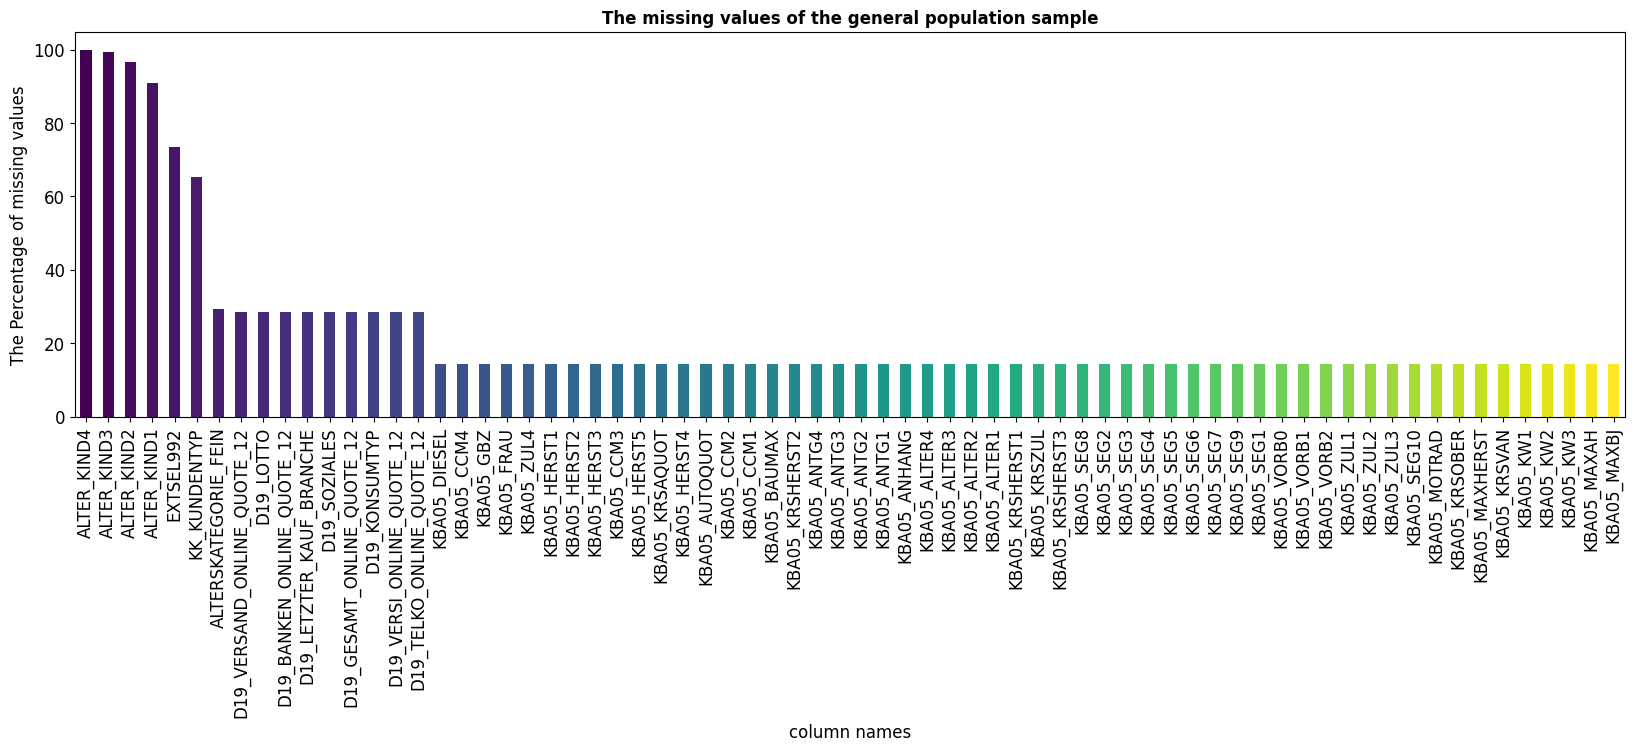

In [62]:
# we can visualize it 
num_bars = 70
colors = plt.cm.viridis(np.linspace(0, 1, num_bars)) 

plt.title('The missing values of the general population sample', fontsize=12, fontweight="bold")
plt.xlabel('column names', fontsize=12)
plt.ylabel('The Percentage of missing values', fontsize=12)
avergae_missing_values.sort_values(ascending=False)[:num_bars].plot(kind='bar', figsize=(20,5), fontsize=12, color=colors)

# The analysis of plot below:

-Missing values by columns:

    This plot is showing you the percentage of missing values the columns have. As we can see, a high number starts from 0 to 20% of missing values. However we didn't remove columns based on 20% of missing values but for also unnecessary columns.


Text(0, 0.5, 'count')

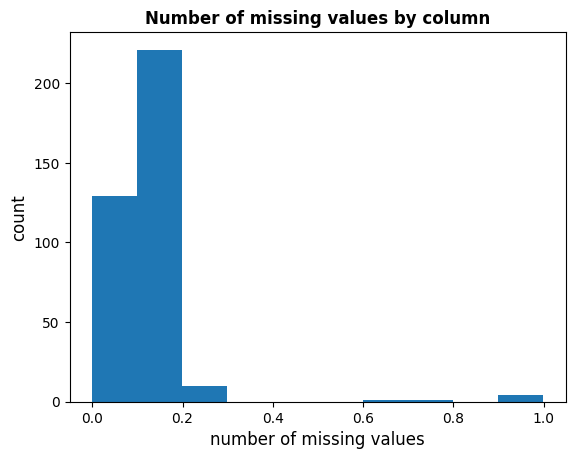

In [63]:
missing_values = (azdias.isnull().sum()/azdias.shape[0])

plt.hist(missing_values)
plt.title("Number of missing values by column",fontsize=12,fontweight="bold")
plt.xlabel("number of missing values",fontsize=12)
plt.ylabel("count",fontsize=12)

# The analysis of plot below:

-Missing values by rows:

    This plot is showing you the number of missing values(count) the attributes have. As we can see, a high number starts from 0 till aprox. 25 attributes of missing values. So the rows were removed from 25 till 0, since it holds the highest number of missing values. 

Text(0, 0.5, 'count')

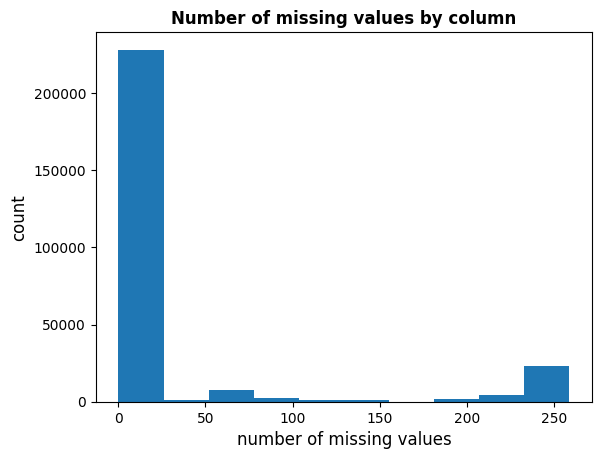

In [64]:
#visualising the missing values in rows
missing_values_rows = azdias.isnull().sum(axis=1)
plt.hist(missing_values_rows)
plt.title("Number of missing values by column",fontsize=12,fontweight="bold")
plt.xlabel("number of missing values",fontsize=12)
plt.ylabel("count",fontsize=12)

In [65]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [66]:
#we just knew the columns that were missing values more than 20 percent of columns and 
#kept the columns in a list to drop them
missing_values_list = []
for i in azdias.columns:
    count_percent = azdias[i].isnull().sum()/azdias.shape[0]
    

    if count_percent > 0.20:
        missing_values_list.append(i)


#         nan_dict[i] = count_percent
#we just dropped the columns that were missing values more than 15 percent of missing info    
print('columns to drop: ', missing_values_list)

columns to drop:  ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP']


# Note about the dropping of columns: 

    There are number of additional columns that we want to drop for reasonable factors, either they have too many different items that are only a noise to the dataset or their values might not be used effectively in here. So i decided to delete them. The columns of KBA05 for example are all about cars, i decided to delete them as well, as i am looking for a critria in charachteristics(e.g., does saving money increase the likelihood of becoming a customer for mail-order or not!) in people and so i dropped them. 

In [67]:
df_list = ['RT_KEIN_ANREIZ',
 'CJT_TYP_6',
 'CJT_TYP_2',
 'EINGEZOGENAM_HH_JAHR',
 'CJT_KATALOGNUTZER',
 'VK_ZG11',
 'UMFELD_ALT',
 'RT_SCHNAEPPCHEN',
 'AGER_TYP',
 'ALTER_HH',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'TITEL_KZ',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'LP_FAMILIE_FEIN',
 'LP_STATUS_FEIN',
 'ANREDE_KZ',
 'GREEN_AVANTGARDE',
 'SOHO_KZ',
 'VERS_TYP',
 'LP_LEBENSPHASE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'EINGEFUEGT_AM',
 'PRAEGENDE_JUGENDJAHRE',
 'PLZ8_BAUMAX',
 'LNR']

In [68]:
#the list of columns that starts with 'KBA05':
KBA05_list = []
for f in azdias.columns:
    if 'KBA05' in f:
        KBA05_list.append(f)
        
print('columns to drop that starts with KBA05: ', KBA05_list)

len(KBA05_list)

columns to drop that starts with KBA05:  ['KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MODTEMP', 'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10', 'KBA05_SEG2', 'KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VORB0', 'KBA05_VORB1', 'KBA05_VORB2', 'KBA05_ZUL1', 'KBA05

65

# Mixed Data values in columns: 

Fix data types from strings(object) to numeric type and there are 'X'/'XX' in the objects columns among numbers so we will have to delete them.  

-Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS").

In [69]:
#selecting categorical columns for feature engineering so we had to re-encode them and delete most of them
azdias.select_dtypes(exclude=['number']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W


In [70]:
azdias['CAMEO_DEUG_2015'].values

array([nan, 8.0, 4.0, ..., '8', '6', '4'], dtype=object)

In [71]:
azdias['OST_WEST_KZ'].values

array([nan, 'W', 'W', ..., 'W', 'W', 'W'], dtype=object)

In [72]:
print(azdias.iloc[:,18:20].columns)

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [73]:
print(azdias.iloc[:,18].unique())

[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']


In [74]:
print(azdias.iloc[:,19].unique())

[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


In [75]:
print(azdias.iloc[:,19].value_counts())

CAMEO_INTL_2015
51      21571
51.0    18943
41      14899
24      14745
41.0    13286
24.0    13143
14      10192
43       9225
14.0     8949
43.0     8223
54       7382
54.0     6463
25       6375
25.0     5573
22       5397
22.0     4790
23       4429
13       4308
45       4142
23.0     3778
55       3733
13.0     3695
45.0     3629
55.0     3296
52       3226
52.0     3014
34       3012
31       3000
31.0     2752
15       2685
34.0     2640
15.0     2487
44       2408
12       2235
44.0     2106
12.0     1897
32       1769
33       1676
35       1625
32.0     1476
35.0     1465
33.0     1390
XX        104
Name: count, dtype: int64


In [76]:
#Beofre cleaning the data, this is the sum of nan values in the table by all the columns that contains it
print("Counting Nan values", azdias.isnull().sum().sum())

Counting Nan values 9868215


# Cleaning azdias dataset to prepare it for the further analysis:

# Note: Missing values with imputation: 

Even though we dealt with missing values in columns and rows, there are still missing values in columns, and so for that we used SimpleImputer class in the clean_data function in Customer Segementation.py that is provided for you.

In [77]:
cleaned_azdias = clean_data(azdias)

A) The First Step: Dropping the unnecessary columns.
The columns that were successfully dropped are: 
 1) Columns that have more than 20% of missing values. 
 2) Columns that have no description in the files. 
 3) Columns that are noisy because it contains many different items. 
 4) The ID Column.
Creating a copy of the dataframe after dropping columns. 

B) The Second Step: Remove rows with less than 25 missing attributes. 

C) The Third Step: Replace O with 0 and W with 1 in OST_WEST_KZ attribute. 

D) The Fourth Step: Rename the WOHNLAGE column to TYPE_RESIDENTIAL_AREA. 

E) The Fifth Step: apply feature engineering on TYPE_RESIDENTIAL_AREA values. It is better to reduce the noise. 

F) The Sixth Step: Dropping the original column: WOHNLAGE. 

Feature extracting CAMEO_DEUG_2015. 

G) The Seventh Step: Checking the values of the object type column: CAMEO_DEUG_2015 and transforming to a numeric type. 

H) The Eighth Step: removing columns with start with KBA05. 
 
 I) The Nineth Step:

In [78]:
cleaned_azdias.head(10)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_TYP_1,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_MOBILE,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_GROB,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,STRUKTURTYP,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,ALTERSKATEGORIE_GROB,TYPE_RESIDENTIAL_AREA
0,1.0,15.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,6.0,3.0,2.0,1.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,3.0,3.0,4.0,5.0,3.0,4.0,4.0,1.0,4.0,40.0,10.0,-1.0,0.0,2.0,5.0,3.0,3.0,

In [79]:
cleaned_azdias.shape

(41073, 247)

In [80]:
# Apply feature scaling to the general population demographics data(azdias).
scaler = StandardScaler()

cleaned_azdias[cleaned_azdias.columns] = scaler.fit_transform(cleaned_azdias)

In [81]:
cleaned_azdias.head(10)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_TYP_1,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_MOBILE,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEMEINDETYP,GFK_URLAUBERTYP,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_GROB,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,STRUKTURTYP,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,ALTERSKATEGORIE_GROB,TYPE_RESIDENTIAL_AREA
0,-0.529600,0.062885,-0.145747,-0.063242,-0.269554,-0.410877,-0.153014,-0.041536,0.060124,0.373584,-0.333967,-1.426463,-2.295515,0.886059,0.898858,0.760860,-0.180692,-0.232572,-0.332543,-0.261000,-0.114498,-0.224904,-0.24704,-0.391148,-0.21291,-0.145223,-0.421889,-0.149251,-0.309115,-0.181702,-0.289553,-0.170313,-0.456206,-0.524034,

# Part 1 Customer Segmenation: 

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

-Apply PCA to the data:


# PCA Interpretation:


In [82]:
pca = PCA()

azdias_PCA = pca.fit(cleaned_azdias)

#features is the number of columns from 0-244
features = range(pca.n_components_)
features

range(0, 247)

In [83]:
data_pca = azdias_PCA.transform(cleaned_azdias)
data_pca

array([[-4.23091842e+00,  1.79247957e-01, -2.36601218e-02, ...,
        -3.75912039e-03,  2.30781423e-03, -2.81695262e-16],
       [-4.71574676e+00, -5.29811355e-02, -7.26215891e-01, ...,
        -1.11147847e-03,  5.24461356e-04,  3.67014000e-17],
       [ 9.08921862e+00,  9.72012242e+00, -5.44140711e+00, ...,
        -2.32447382e-02, -2.51542527e-01, -1.26954664e-15],
       ...,
       [ 9.24490230e+00,  6.23224047e+00, -1.27972494e+00, ...,
         1.70584858e-02, -9.70426155e-03, -1.60923040e-15],
       [ 3.96798588e+00,  3.36143820e+00,  6.31322130e+00, ...,
         9.38579991e-02, -1.27774098e-03, -9.09582066e-16],
       [ 9.53903695e+00, -5.15207317e+00, -2.47414843e+00, ...,
        -5.34553556e-01,  2.11779252e-01, -6.48989223e-16]])

In [84]:
explained_variance_ratio = sum(pca.explained_variance_ratio_)

In [85]:
print("The variance ratio:", explained_variance_ratio.round(2) * 100)

The variance ratio: 100.0


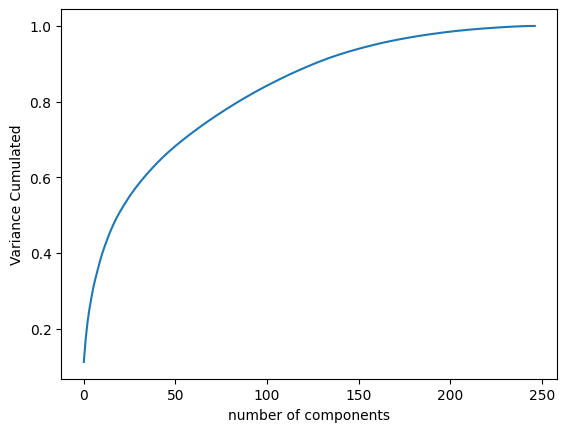

In [86]:
#to visualise it using plot:
#number of components is 244
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('Variance Cumulated')
plt.show()

# Apply 170 componets to PCA

Why PCA?:

    1) PCA can tell us the important information regarding a dataset like signficant patterns/trends with giving them either negative weights or positive weights.
    2) It also reduces the dimensionality of the dataset without the harm of not capturing the major trends. This reduction develops the model and helps overfitting in a model and decreases the amount of time the model has to train.


    -My choice of this number of compenents is to choose smallest number of components that still 
    capture most of the information in our data, enough components to cover about 95% of the total data variance.

In [87]:
pca2 = PCA(170)

PCA_azdias = pca2.fit_transform(cleaned_azdias)
PCA_azdias

array([[-4.23091842,  0.17924796, -0.02366012, ...,  0.22179721,
        -0.09992416,  0.08490078],
       [-4.71574676, -0.05298114, -0.7262159 , ..., -0.0230763 ,
         0.02562649, -0.03736543],
       [ 9.08921862,  9.72012241, -5.44140717, ...,  0.57236578,
         0.60894546,  0.07885789],
       ...,
       [ 9.2449023 ,  6.23224047, -1.27972494, ..., -1.07267534,
         0.59796677,  1.38374489],
       [ 3.96798588,  3.36143823,  6.31322142, ...,  0.48102104,
         0.56452806, -0.33882956],
       [ 9.53903695, -5.15207314, -2.47414841, ...,  1.27696936,
        -0.57337691, -0.50096324]])

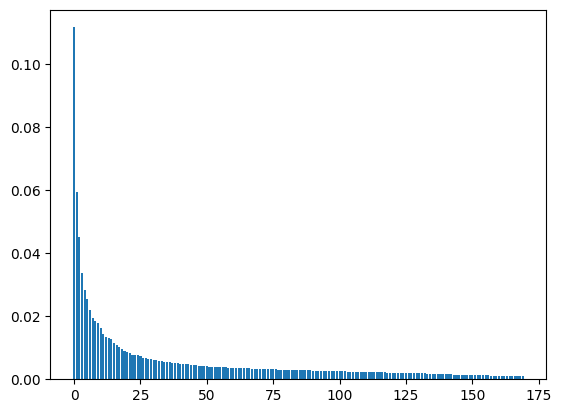

In [88]:
#features are 170
features = range(pca2.n_components_)
plt.bar(features, pca2.explained_variance_ratio_)
plt.show()

In [89]:
explained_variance_ratio_pca = sum(pca2.explained_variance_ratio_)
explained_variance_ratio_pca

0.961134932657238

In [90]:
print("The variance ratio:", explained_variance_ratio_pca.round(2) * 100)

The variance ratio: 96.0


# PCA Interpretation:

In [91]:
#First pca:
from Customer_Segmentation import print_features_pca
i=1
print('{:5.2%}'.format(pca2.explained_variance_ratio_[i]))
      
print_features_pca(cleaned_azdias.columns.values, pca2.components_, i)


5.93%
The lowest features: 
KBA13_ALTERHALTER_60 -0.1677828641960515
KBA13_HALTER_50 -0.14895108516533945
KBA13_HALTER_55 -0.14875497309867466
KBA13_AUTOQUOTE -0.14810844725252856
KBA13_SITZE_5 -0.1319112442335432
The heighest features: 
KBA13_SITZE_4 0.14800810802194272
EWDICHTE 0.15625176022778725
ORTSGR_KLS9 0.16048524599799413
KBA13_ANTG3 0.16087381693695638
KBA13_HERST_BMW_BENZ 0.16131998873495876


Let's discuss the first PCA most important features that have lowest/negative weights and highest/positive weights:
These features have been described in a file that is found downloaded between the files:


Overall Variance:

    -5.93% Variance: This principal component explains 3.40% of the total variance in the data. PCA often involves multiple components, each capturing different aspects of the data. The first few components usually capture the most significant variance.

What is meant by negative weights and how is it related to the features?
The features which have negative weights, indicate that they have a negative relationship with the principal component. 

-Lowest weights:

    KBA13_SITZE_5: number of cars with 5 seats in the PLZ8. (1= VERY LOW, 5= VERY HIGH).

    KBA13_AUTOQUOTE: share of cars per household within the PLZ8. (1= VERY LOW, 5= VERY HIGH).

    KBA13_HALTER_55 and KBA13_HALTER_50: share of car owners between 46 and 50 within the PLZ8 & share of car owners between 51 and 55 within the PLZ8. (1= VERY LOW, 5= VERY HIGH).

    KBA13_ALTERHALTER_60 is share of car owners between 46 and 60 within PLZ8. (1= VERY LOW, 5= VERY HIGH).

   Highest weights:

    KBA13_HERST_BMW_BENZ: share of BMW & Mercedes Benz within the PLZ8. (1= VERY LOW, 5= VERY HIGH).

    ORTSGR_KLS9: size of the community which means the number inhabitants. (1= <= 2.000 inhabitants, 9 = >700 inhabitants).

    EWDICHTE: density of inhabitants per square kilometer. (1= less than 34 HH/km² , 6 = more than 999 HH/km²).

    KBA13_ANTG3 is estimate a number of 6-10 family houses in the PLZ8. (3 = very high share).

    KBA13_SITZE_4: number of cars with less than 5 seats in the PLZ8. (1= VERY LOW, 5= VERY HIGH).

Analysis: 

First PCA tells us that it is asccoiated with person's transportation, how many cars each household have and how many shares a family have. Additionaly, there is a high probability that a person have BMW and Mercedes shares, which this might indicate that a person who earn good amount of money is likely to become customer of the campaign


The third PCA:


In [92]:
#Second pca:
#i wanted to do an extra analysis for the pca but i wanted to choose a random number
i=3
print('{:5.2%}'.format(pca2.explained_variance_ratio_[i]))
      
print_features_pca(cleaned_azdias.columns.values, pca2.components_, i)

3.36%
The lowest features: 
FINANZ_VORSORGER -0.2127051094223222
VK_DHT4A -0.1699105239517667
ALTERSKATEGORIE_GROB -0.15783005632082023
FINANZ_MINIMALIST -0.14588052830686032
RETOURTYP_BK_S -0.14321244735754285
The heighest features: 
CJT_TYP_1 0.17973257933719533
SEMIO_TRADV 0.1803884703786086
ALTERSKATEGORIE_FEIN 0.1831366674099007
FINANZ_UNAUFFAELLIGER 0.18401766965622432
FINANZ_SPARER 0.21357299203509333


Let's discuss the second PCA's most important features:

Overall Variance:

    -3.40% Variance: This principal component explains 3.40% of the total variance in the data. PCA often involves multiple components, each capturing different aspects of the data. The first few components usually capture the most significant variance.

What is meant by negative weights and how is it related to the features?
The features which have negative weights, indicate that they have a negative relationship with the principal component. 
    
    
-Lowest weights:

    -FINANZ_VORSORGER: financial typology: be prepared. (1= VERY HIGH, 5= VERY LOW).

    -ALTERSKATEGORIE_GROB: age classification through prename analysis  (1 < 30 YEARS, 4> 60 YEARS).

    -RETOURTYP_BK_S: shoper type. (1 = influenceable crazy shopper, 5 = determined Minimal-Returner)

-Highest weights:



    SEMIO_TRADV : affinity indicating in what way the person is traditional minded. (1= highest affinity, 7= lowest affinity).

    ALTERSKATEGORIE_FEIN : age classification through prename analysis. (1 < 30 YEARS, 4> 60 YEARS).

    FINANZ_UNAUFFAELLIGER:  financial typology: unremarkable. (1= VERY HIGH, 5= VERY LOW).

    FINANZ_SPARER : financial typology: money saver. (1= VERY HIGH, 5= VERY LOW).
    
Analysis: 

The third PCA is associated with financial typology and money savers and age.
Higher weights and the higher compenets relates to higher probability of people who are older, money savers and people who buy a lot are likely to become mail-order company's customer.

# Clustering:

Clustering is an unsupervised learning technique which is powerful because it can simplify large, complex datasets with many features to a single cluster based on their intrinsic characteristics or similarities.

How to choose the clusters number, why and based on what?

    Selecting clusters is very cruical in data analysis as it directly affects the results and the perfornace of the model. So choosing a number of clusters has to be done carefully and optimally. One method for it is using the Elbow method in K-Means Clustering.



Text(0.5, 0, 'Number of Clusters')

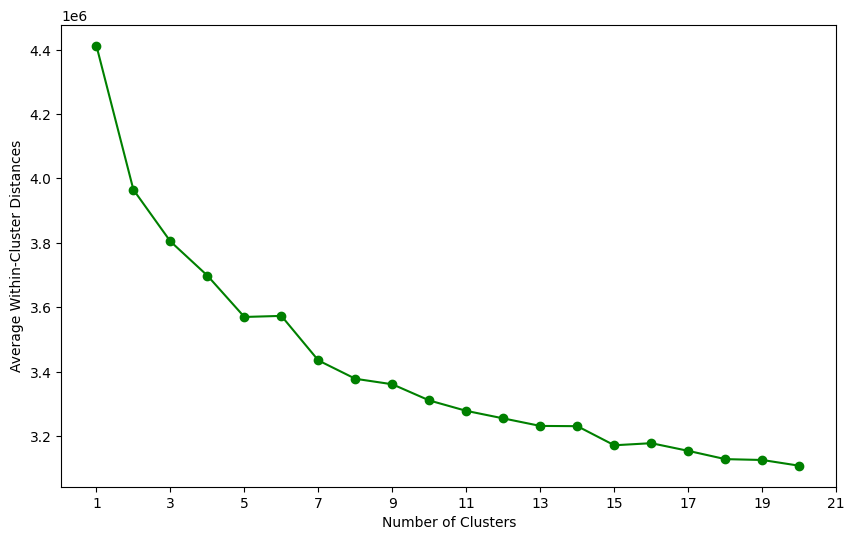

In [93]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

scores = []
for i in range(1, 21):
    scores.append(score(PCA_azdias[:20000], i))

    
centers = np.linspace(1,20,20)
plt.figure(figsize=(10,6))
plt.plot(centers, scores, linestyle='-', marker='o', color='green')
plt.xticks(list(range(1,22,2)))
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

In order to know the optimal number of clusters, we plotted the Elbow plot from 1 to 21. The Elbow method plots the average within-cluster distances (inertia) against the number of components. 

How was the Elbow point identified?

    The point where the slope of the curve decreases sharply. In our case, i chose 16 because after 16 it keeps decreasing for the high number of clusters but with lower slope.


# Pipeline:



In [94]:
n_components = 170
n_clusters = 16

model_pipe = Pipeline([('pca', PCA(n_components)), ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
                  ])

model_pipe.fit(cleaned_azdias)
prediction_azdias = model_pipe.predict(cleaned_azdias)
prediction_azdias



array([ 1,  1,  9, ..., 11,  3,  2], dtype=int32)

# A new Series:


In [95]:
new_azdias = pd.Series(prediction_azdias).value_counts().reset_index()

new_azdias.columns = ['Cluster', 'Count']

new_azdias['Dataset_Name'] = 'Azdias'

new_azdias['Proportion'] = new_azdias['Count'] / cleaned_azdias.shape[0]
new_azdias

,Cluster,Count,Dataset_Name,Proportion
0,1,21526,Azdias,0.524091
1,12,2602,Azdias,0.063351
2,14,2512,Azdias,0.061159
3,11,1749,Azdias,0.042583
4,7,1505,Azdias,0.036642
5,10,1469,Azdias,0.035766
6,8,1427,Azdias,0.034743
7,2,1189,Azdias,0.028948
8,9,1180,Azdias,0.028729
9,6,1166,Azdias,0.028388


# Now the same Data cleaning, PCA, Clustering, Pipeline Proceduers must be performed on the customers dataset: 

Now we are ready to run the steps above on the customers dataset. The 'customers' dataframe contains 3 extra columns: 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'. We will drop these columns for this part of the analysis.

In [96]:
customers.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

# The analysis of plot below:

    -This plot is showing you the percentage of missing values the columns have. As we can see, a high number starts from 0 to 20% of mssing values. However we didn't remove columns based on 20% of missing values but for also unnecessary columns.


Text(0, 0.5, 'count')

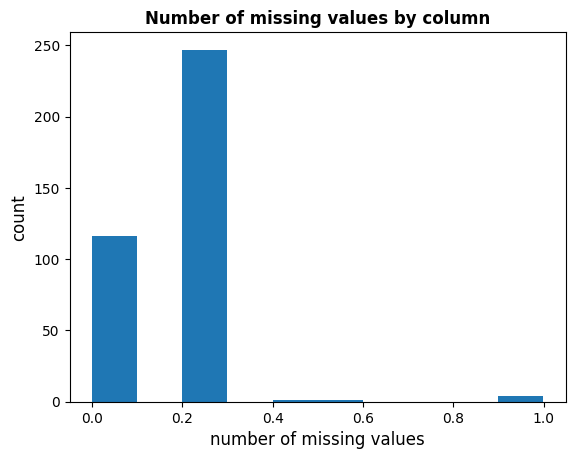

In [97]:
missing_values_2 = (customers.isnull().sum()/customers.shape[0])

plt.hist(missing_values_2)
plt.title("Number of missing values by column",fontsize=12,fontweight="bold")
plt.xlabel("number of missing values",fontsize=12)
plt.ylabel("count",fontsize=12)

In [98]:
print("Cleaning Customers dataset")

cleaned_customers = clean_data(customers)


Cleaning Customers dataset
A) The First Step: Dropping the unnecessary columns.
The columns that were successfully dropped are: 
 1) Columns that have more than 20% of missing values. 
 2) Columns that have no description in the files. 
 3) Columns that are noisy because it contains many different items. 
 4) The ID Column.
Creating a copy of the dataframe after dropping columns. 

B) The Second Step: Remove rows with less than 25 missing attributes. 

C) The Third Step: Replace O with 0 and W with 1 in OST_WEST_KZ attribute. 

D) The Fourth Step: Rename the WOHNLAGE column to TYPE_RESIDENTIAL_AREA. 

E) The Fifth Step: apply feature engineering on TYPE_RESIDENTIAL_AREA values. It is better to reduce the noise. 

F) The Sixth Step: Dropping the original column: WOHNLAGE. 

Feature extracting CAMEO_DEUG_2015. 

G) The Seventh Step: Checking the values of the object type column: CAMEO_DEUG_2015 and transforming to a numeric type. 

H) The Eighth Step: removing columns with start with KBA

In [99]:
#shape of the cleaned customers:
cleaned_customers.shape

(56508, 247)

In [100]:
print("Scaling the Customers dataset")
scaler = StandardScaler()

cleaned_customers[cleaned_customers.columns] = scaler.fit_transform(cleaned_customers)

Scaling the Customers dataset


In [101]:
model_pipe.fit(cleaned_customers)
prediction_customers = model_pipe.predict(cleaned_customers)
prediction_customers

array([15,  8,  8, ...,  6,  2,  7], dtype=int32)

In [102]:
new_customers = pd.Series(prediction_customers).value_counts().reset_index()

new_customers.columns = ['Cluster', 'Count']

new_customers['Dataset_Name'] = 'Customers'

new_customers['Proportion'] = new_customers['Count'] / cleaned_customers.shape[0]
new_customers

,Cluster,Count,Dataset_Name,Proportion
0,1,46614,Customers,0.824910
1,15,1785,Customers,0.031588
2,6,1229,Customers,0.021749
3,8,1157,Customers,0.020475
4,4,815,Customers,0.014423
5,7,744,Customers,0.013166
6,10,695,Customers,0.012299
7,13,625,Customers,0.011060
8,5,585,Customers,0.010353
9,2,528,Customers,0.009344


# Comparing Customer Dataset to the sample size of General Population/Azdias Dataset(Demographics Data):

In this step, we want to identify if there are any differences between the relative population size assigned to each cluster in the general and customer datasets. Thus, we plot the relative size of samples on each cluster and compare the results. From the plot results we observe that there are some clusters where the customers population is over-represented compared to the general population. Hence, the individuals from the general population assigned to these clusters, are more likely to become new clients.

In [103]:
new_dataframe = pd.concat([new_azdias.groupby(['Cluster']).agg({'Proportion': 'sum'}),
                          new_customers.groupby(['Cluster']).agg({'Proportion': 'sum'})], axis=1)

new_dataframe.columns = ['General Population', 'Customers']

new_dataframe['Difference'] = new_dataframe['General Population'] - new_dataframe['Customers']

new_dataframe.head(10)

,General Population,Customers,Difference
Cluster,,,
0,0.026757,0.003221,0.023536
1,0.524091,0.824910,-0.300818
2,0.028948,0.009344,0.019605
3,0.023811,0.008477,0.015335
4,0.001315,0.014423,-0.013108
5,0.015582,0.010353,0.005229
6,0.028388,0.021749,0.006639
7,0.036642,0.013166,0.023476
8,0.034743,0.020475,0.014268


# Visualisation of the difference between the customer data and the sample size of the general population

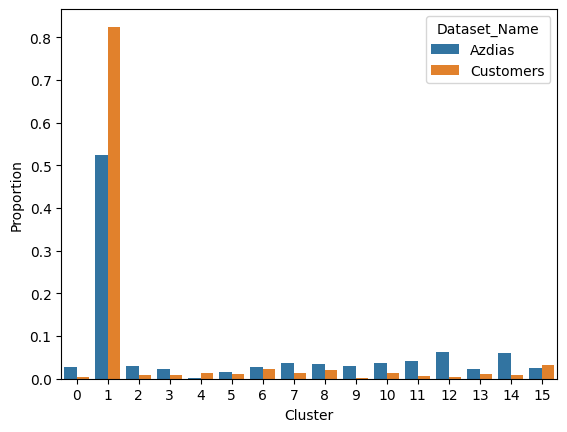

In [104]:
comparison_dataset = pd.concat([new_azdias, new_customers], axis = 0 ,sort=True)     
sb.barplot(x = 'Cluster', y = 'Proportion', hue = 'Dataset_Name', data = comparison_dataset)
plt.show()

* We can see that there are some clusters from the customers dataset that are overrepresented compared to the sample size of the general population, which indicates that the population from these clusters can highly become future customers.

Also, We can conclude that people who are likely to be customers for mail order have the features we analysed above in PCA:

    a- People who buy a lot or have high order/online transaction activities.
    b- People who are old.
    c- People who hold a good number of shares.
    d- People who save money.

